In [1]:
from IPython.display import display, clear_output
import keyboard
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ['cmr10'],
    "axes.labelsize": 22, 
    "axes.titlesize": 22, 
    "xtick.labelsize": 18, 
    "ytick.labelsize": 18, 
    "legend.fontsize": 20,
    "figure.figsize": [12, 7], 
    "figure.dpi": 300 
})
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from keras.constraints import NonNeg
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

In [2]:
def t_w (w, k, Omega, DeltaE, gamma, g):
    numerador = -k
    denominador = (Omega-w) - 1j * k - 1j * g**2 / (1j * (DeltaE - w) + gamma)
    t = numerador / denominador
    return abs(t)

Omega = 1

In [3]:
# Definimos una función que genere la base de datos
def Parameters_generator (num_datos):
    k = np.random.uniform(1e-4, 1e-2, num_datos)
    DeltaE = np.random.uniform(0.5, 1.5, num_datos)
    gamma = np.random.uniform(1e-4, 1e-2, num_datos)
    g = np.random.uniform(1e-4, 1e-2, num_datos)

    return k, DeltaE, gamma, g

num_datos = 10000

In [4]:
def Dense_five (input_neurons, output_neurons):
    model = Sequential()
    model.add(Input(shape=(input_neurons,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(output_neurons, activation='linear', kernel_constraint=NonNeg())) 

    #Compila el modelo
    model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mean_absolute_error'])
    return model


# Crear base de datos

In [5]:
# Definimos una función que genere la base de datos
def Parameters_generator (num_datos):
    k = np.random.uniform(1e-4, 1e-2, num_datos)
    DeltaE = np.random.uniform(0.5, 1.5, num_datos)
    gamma = np.random.uniform(1e-4, 1e-2, num_datos)
    g = np.random.uniform(1e-4, 1e-2, num_datos)

    return k, DeltaE, gamma, g

num_datos = 10000

In [6]:
# # #Creamos base de datos y guardamos en .txt
# k, DeltaE, gamma, g = Parameters_generator (num_datos)
# np.savetxt('Parameters_previous-set.txt', np.column_stack((k, DeltaE, gamma, g))) 

In [7]:
datos = np.loadtxt('Parameters_previous-set.txt')
k = datos[:,0]
DeltaE = datos[:,1]
gamma = datos[:,2]
g = datos[:,3]

#Creamos los valores de y (la función t(w)) con nuestra base de datos
w_values = np.linspace(0.85, 1.15, 300)

# Crear una matriz para almacenar los t(w)
t_values = np.zeros((num_datos, len(w_values)))

# Almacenar los resultados en la matriz 
# (elemento [i,j] fila i es el número de combinación de [k, DeltaE, gamma, g] 
# y la comluna j el elemento de w_values)
for i in range (num_datos):
    t_values[i,:] = t_w(w_values, k[i], Omega, DeltaE[i], gamma[i], g[i])

# Dividir los datos en entrenamiento y validación
x_train, x_post, y_train, y_post = train_test_split(t_values, datos, test_size=0.2)
x_val, x_test, y_val, y_test = train_test_split(x_post, y_post, test_size=0.5)

# Normalizamos los datos
scaler_x = RobustScaler()
x_train_norm = scaler_x.fit_transform(x_train)
x_val_norm = scaler_x.transform(x_val)
x_test_norm = scaler_x.transform(x_test)

scaler_y = RobustScaler()
y_train_norm = scaler_y.fit_transform(y_train)
y_val_norm = scaler_y.transform(y_val)
y_test_norm = scaler_y.transform(y_test)

input_neurons = x_train.shape[1]
output_neurons = y_train.shape[1]

# Prueba completa

In [8]:
# # Definir listas de valores para batch_size y epochs
# epochs_list = [10, 50, 100, 250, 500, 1000, 2500, 5000, 10000]
# batch_size_list = [10, 25, 50, 100, 250, 500, 1000]

# # Inicializar matrices para almacenar los resultados
# losses = np.zeros((len(batch_size_list), len(epochs_list)))
# training_times = np.zeros((len(batch_size_list), len(epochs_list)))

# # Entrenar el modelo con diferentes combinaciones de batch_size y epochs
# for i, batch_size in enumerate(batch_size_list):
#     for j, epochs in enumerate(epochs_list):
#         model = Dense_five(input_neurons, output_neurons)

#         start_time = time.time()
#         history = model.fit(x_train_norm, y_train_norm, batch_size=batch_size, validation_data=(x_val_norm, y_val_norm),
#                         epochs=epochs, verbose=2)
#         end_time = time.time()
#         training_time = end_time - start_time

#         training_times[i, j] = training_time

#         # Evaluar el modelo en los datos de validación
#         scores = model.evaluate(x_test_norm, y_test_norm, verbose=0)
#         final_loss = scores[0]
#         losses[i, j] = final_loss

# np.savetxt('losses_hyperparameters.txt', losses)
# np.savetxt('training_times_hyperparameters.txt', training_times)

## Cuadro de valores

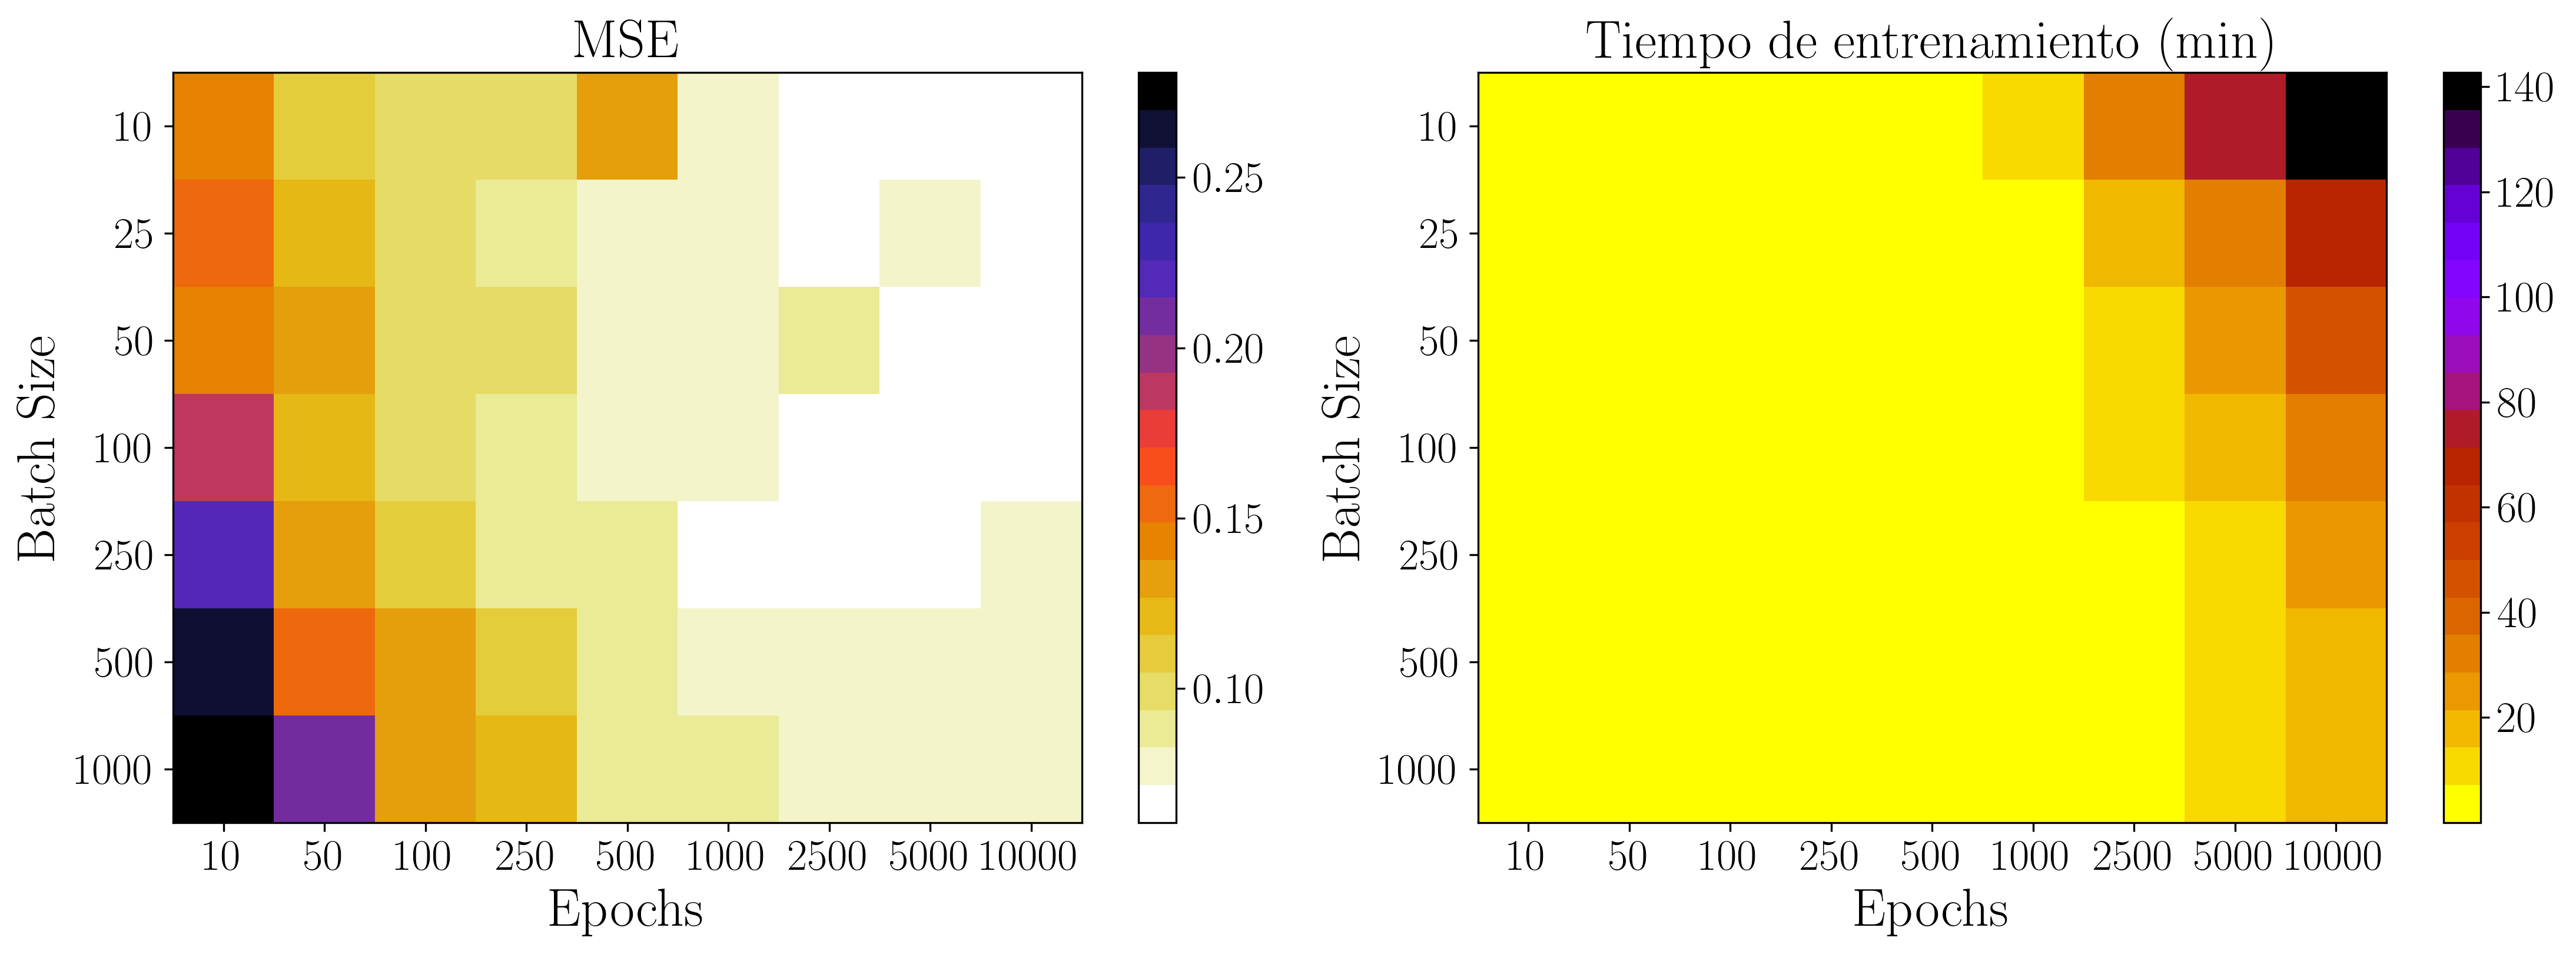

In [9]:
# Leer los archivos de texto
losses = np.loadtxt('losses_hyperparameters.txt')
training_times = np.loadtxt('training_times_hyperparameters.txt')

# Convertir los tiempos de entrenamiento de segundos a minutos
training_times_minutes = training_times / 60.0

# Definir los valores de epochs y batch_size
epochs_list = [10, 50, 100, 250, 500, 1000, 2500, 5000, 10000]
batch_size_list = [10, 25, 50, 100, 250, 500, 1000]

# Crear un mapa de colores personalizado con 30 colores
colors1 = ListedColormap(plt.cm.CMRmap_r(np.linspace(0, 1, 20)))
colors2 = ListedColormap(plt.cm.gnuplot_r(np.linspace(0, 1, 20)))

# Hacer las gráficas
fig, axs = plt.subplots(1, 2, figsize=(15, 5.5))

# Plotear MSE
im_mse = axs[0].imshow(losses, cmap=colors1, aspect='auto')
fig.colorbar(im_mse, ax=axs[0])
axs[0].set_xticks(np.arange(len(epochs_list)))
axs[0].set_yticks(np.arange(len(batch_size_list)))
axs[0].set_xticklabels(epochs_list)
axs[0].set_yticklabels(batch_size_list)
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Batch Size')
axs[0].set_title('MSE')

# Plotear tiempo de entrenamiento
im_time = axs[1].imshow(training_times_minutes, cmap=colors2, aspect='auto')
fig.colorbar(im_time, ax=axs[1])
axs[1].set_xticks(np.arange(len(epochs_list)))
axs[1].set_yticks(np.arange(len(batch_size_list)))
axs[1].set_xticklabels(epochs_list)
axs[1].set_yticklabels(batch_size_list)
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Batch Size')
axs[1].set_title('Tiempo de entrenamiento (min)')

plt.tight_layout()
plt.show()

# Acotamos

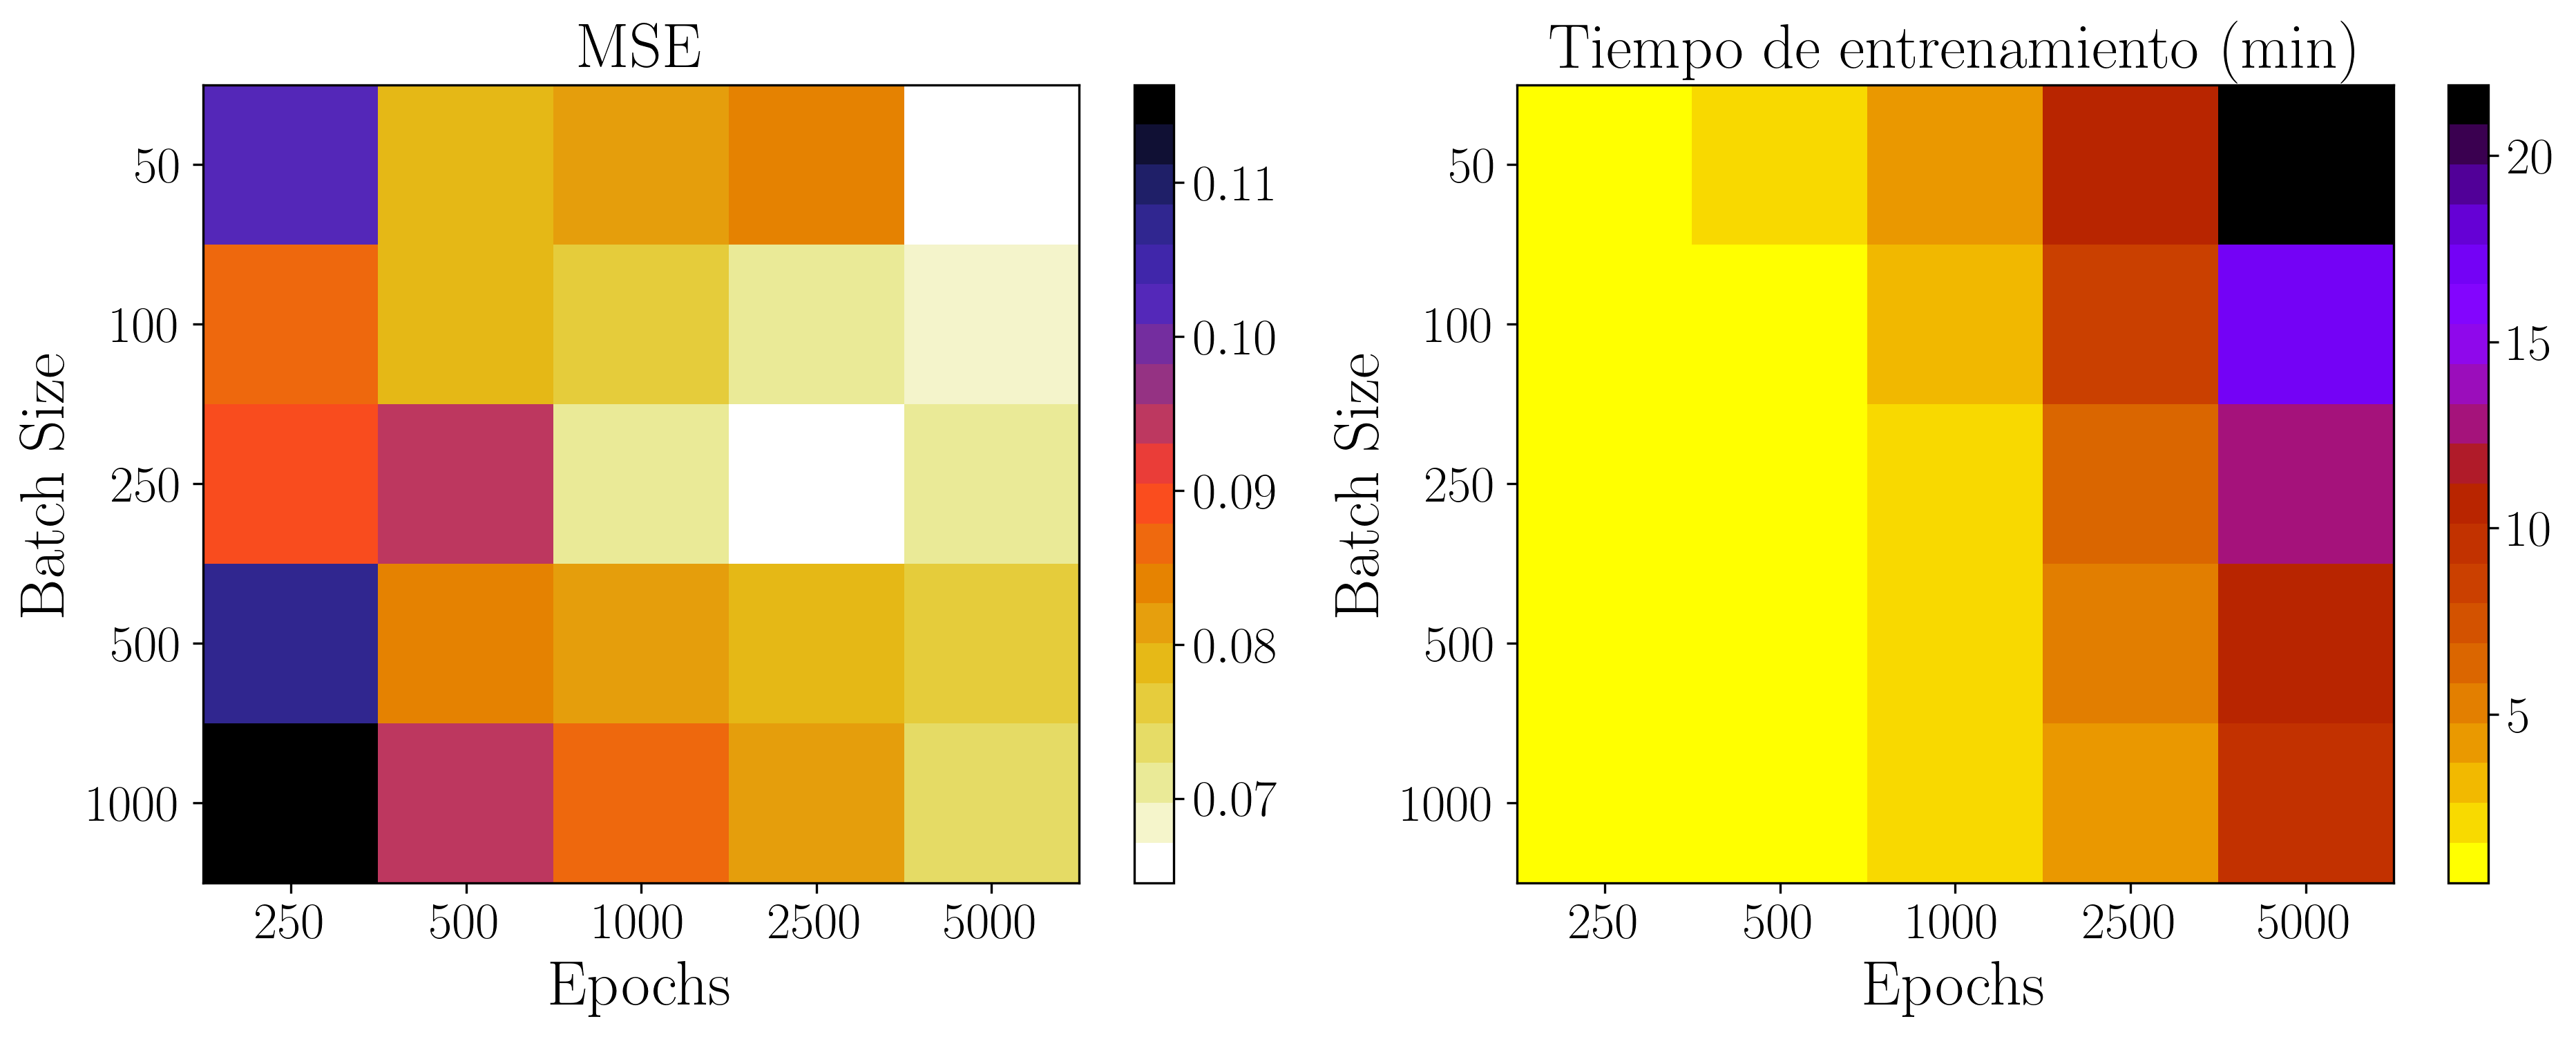

In [10]:
# Leer los archivos de texto
losses = np.loadtxt('losses_hyperparameters.txt', skiprows=2, usecols=range(3, 8))
training_times = np.loadtxt('training_times_hyperparameters.txt', skiprows=2, usecols=range(3, 8))

# Convertir los tiempos de entrenamiento de segundos a minutos
training_times_minutes = training_times / 60.0

# Definir los valores de epochs y batch_size
epochs_list = [250, 500, 1000, 2500, 5000]
batch_size_list = [50, 100, 250, 500, 1000]

# Crear un mapa de colores personalizado con 30 colores
colors1 = ListedColormap(plt.cm.CMRmap_r(np.linspace(0, 1, 20)))
colors2 = ListedColormap(plt.cm.gnuplot_r(np.linspace(0, 1, 20)))

# Hacer las gráficas
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plotear MSE
im_mse = axs[0].imshow(losses, cmap=colors1, aspect='auto')
fig.colorbar(im_mse, ax=axs[0])
axs[0].set_xticks(np.arange(len(epochs_list)))
axs[0].set_yticks(np.arange(len(batch_size_list)))
axs[0].set_xticklabels(epochs_list)
axs[0].set_yticklabels(batch_size_list)
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Batch Size')
axs[0].set_title('MSE')

# Plotear tiempo de entrenamiento
im_time = axs[1].imshow(training_times_minutes, cmap=colors2, aspect='auto')
fig.colorbar(im_time, ax=axs[1])
axs[1].set_xticks(np.arange(len(epochs_list)))
axs[1].set_yticks(np.arange(len(batch_size_list)))
axs[1].set_xticklabels(epochs_list)
axs[1].set_yticklabels(batch_size_list)
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Batch Size')
axs[1].set_title('Tiempo de entrenamiento (min)')

plt.show()

# Acotamos 2

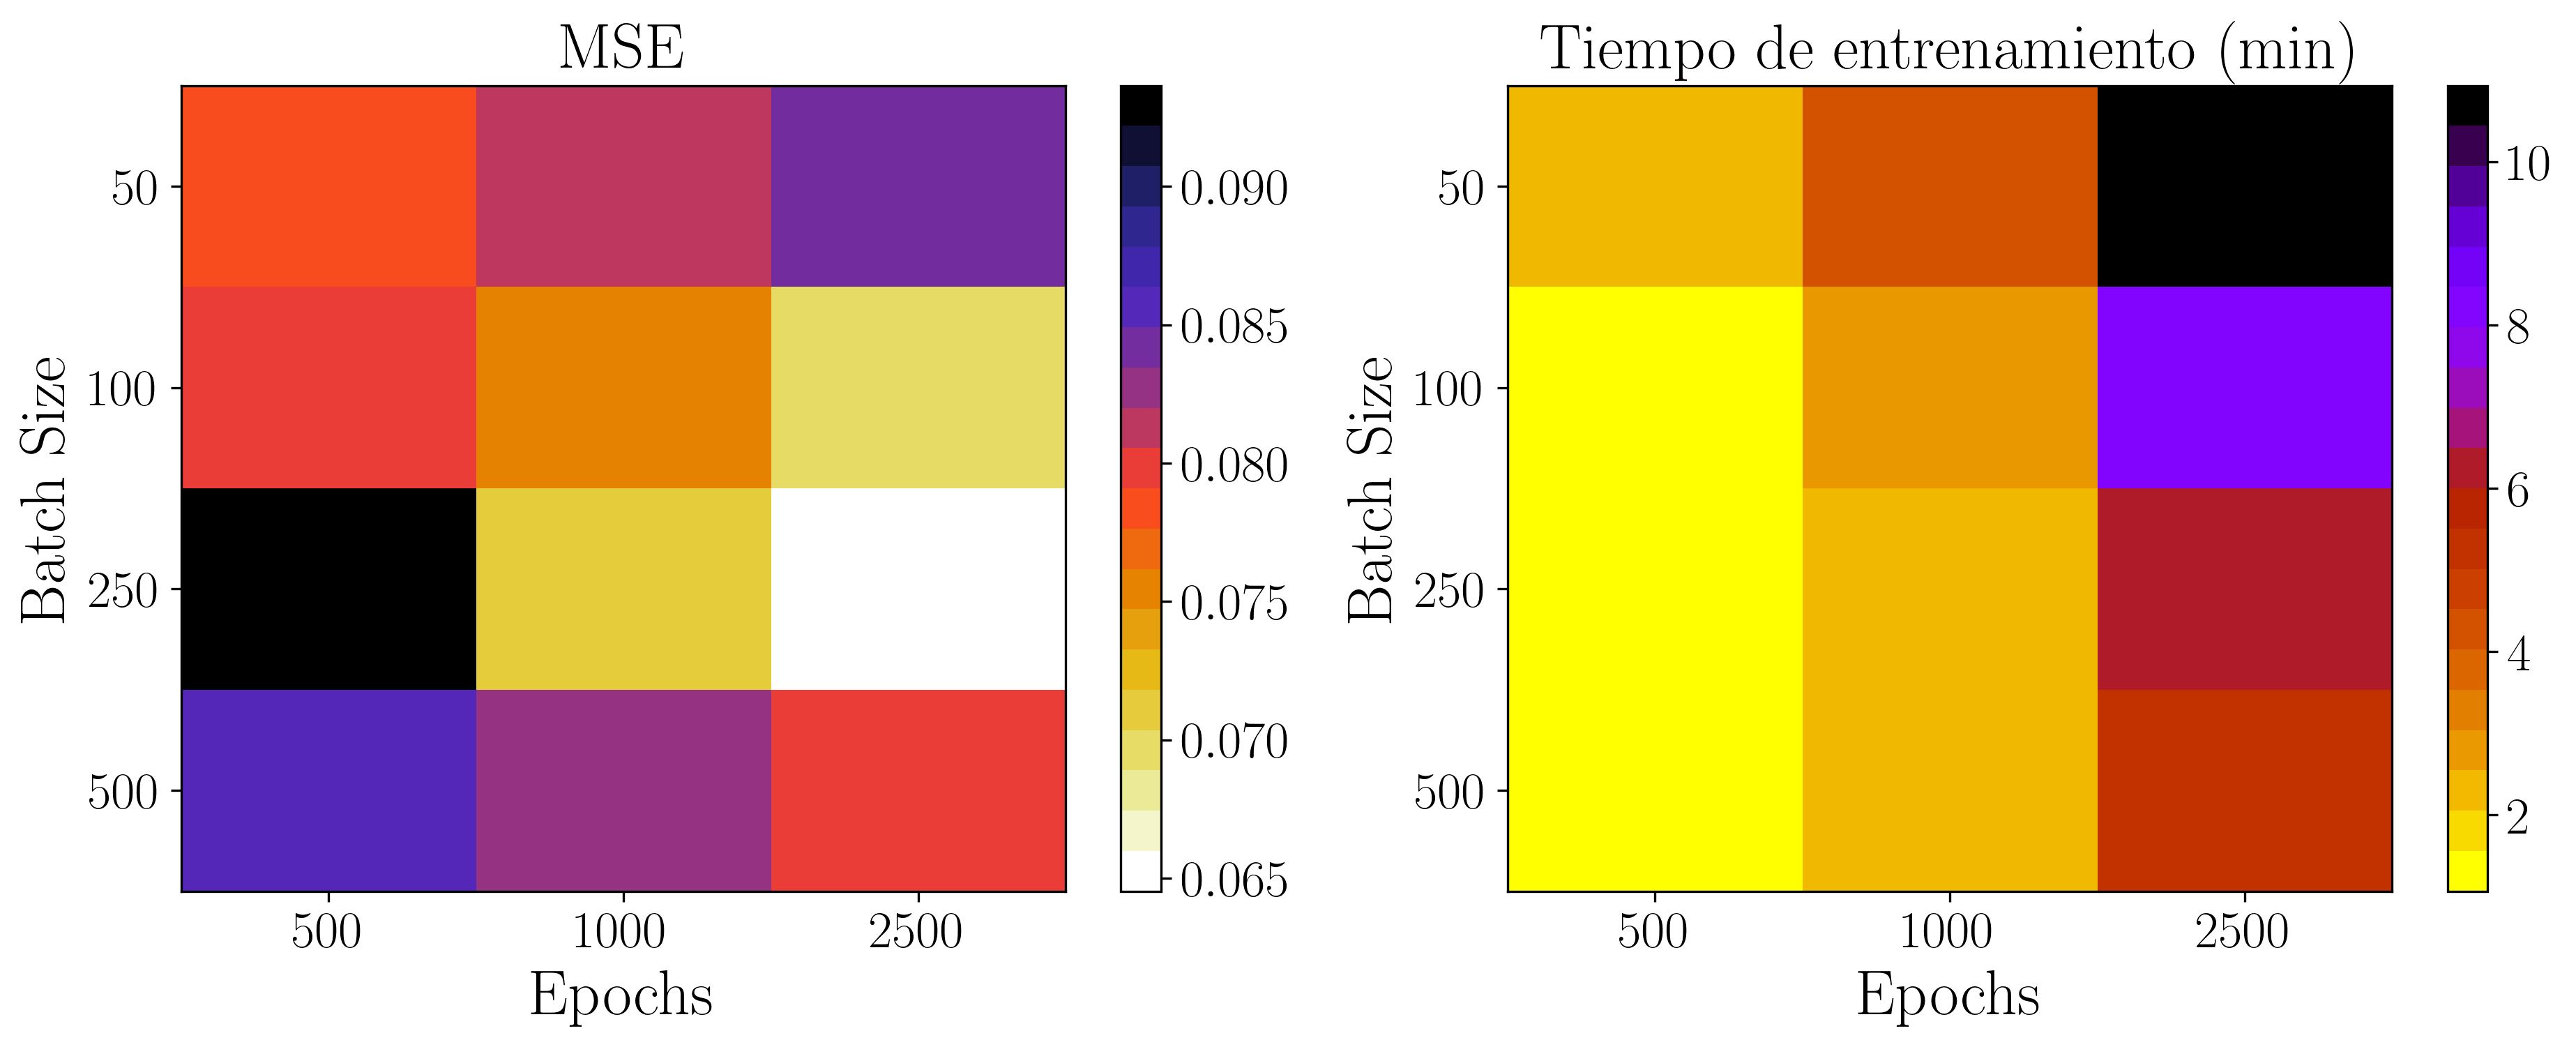

In [11]:
# Leer los archivos de texto
losses = np.loadtxt('losses_hyperparameters.txt', skiprows=2, usecols=range(4, 7), max_rows=4)
training_times = np.loadtxt('training_times_hyperparameters.txt', skiprows=2, usecols=range(4, 7), max_rows=4)

# Convertir los tiempos de entrenamiento de segundos a minutos
training_times_minutes = training_times / 60.0

# Definir los valores de epochs y batch_size
epochs_list = [500, 1000, 2500]
batch_size_list = [50, 100, 250, 500]

# Crear un mapa de colores personalizado con 30 colores
colors1 = ListedColormap(plt.cm.CMRmap_r(np.linspace(0, 1, 20)))
colors2 = ListedColormap(plt.cm.gnuplot_r(np.linspace(0, 1, 20)))

# Hacer las gráficas
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plotear MSE
im_mse = axs[0].imshow(losses, cmap=colors1, aspect='auto')
fig.colorbar(im_mse, ax=axs[0])
axs[0].set_xticks(np.arange(len(epochs_list)))
axs[0].set_yticks(np.arange(len(batch_size_list)))
axs[0].set_xticklabels(epochs_list)
axs[0].set_yticklabels(batch_size_list)
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Batch Size')
axs[0].set_title('MSE')

# Plotear tiempo de entrenamiento
im_time = axs[1].imshow(training_times_minutes, cmap=colors2, aspect='auto')
fig.colorbar(im_time, ax=axs[1])
axs[1].set_xticks(np.arange(len(epochs_list)))
axs[1].set_yticks(np.arange(len(batch_size_list)))
axs[1].set_xticklabels(epochs_list)
axs[1].set_yticklabels(batch_size_list)
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Batch Size')
axs[1].set_title('Tiempo de entrenamiento (min)')

plt.show()